# Structural Time Series Models with Tensorflow Probability

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import time



tf.enable_v2_behavior()

## Filtering & Smoothing

### 1-D Example

In [24]:
num_timesteps = 100
def build_ssm_1d():
    local_ssm = tfp.sts.LocalLinearTrendStateSpaceModel(
        num_timesteps=num_timesteps,
        level_scale=0.5,
        slope_scale=0.1,
        initial_state_prior=tfd.MultivariateNormalDiag(
            loc=[0., 0.],
            scale_diag=[1., 1.])
    )

    day_of_week_ssm = tfp.sts.SeasonalStateSpaceModel(
        num_timesteps=num_timesteps,
        num_seasons=7,
        drift_scale=0.1,
        initial_state_prior=tfd.MultivariateNormalDiag(
            loc=tf.zeros([7]),
            scale_diag=tf.ones([7]))
    )

    additive_ssm = tfp.sts.AdditiveStateSpaceModel(
        component_ssms=[local_ssm, day_of_week_ssm],
        observation_noise_scale=0.1
    )
    return additive_ssm



In [25]:
model=build_ssm_1d()
y = model.sample()


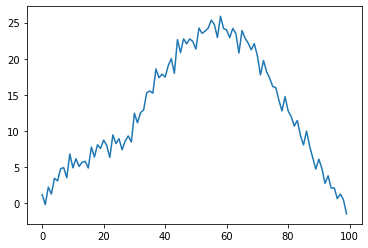

In [15]:
plt.plot(y)

### 2-D Example


In [ ]:
tfp.distributions.LinearGaussianStateSpaceModel(
    num_timesteps, transition_matrix, transition_noise, observation_matrix,
    observation_noise, initial_state_prior, initial_step=0, validate_args=False,
    allow_nan_stats=True, name='LinearGaussianStateSpaceModel'
)


In [52]:
ndims = 2
step_std = 0.1
noise_std = 0.1

model = tfd.LinearGaussianStateSpaceModel(
    num_timesteps=20,
    transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
    transition_noise=tfd.MultivariateNormalDiag(
        scale_diag=step_std**2 * tf.ones([ndims])
    ),
    observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
    observation_noise=tfd.MultivariateNormalDiag(
        scale_diag=noise_std**2 * tf.ones([ndims])),
    initial_state_prior=tfd.MultivariateNormalDiag(
        scale_diag=tf.ones([ndims])
    )
)


In [62]:
samples=2

In [63]:
trajectories = model.sample(samples)

#### Filtering

In [64]:
log_likelihood, filtered_means, filtered_covs, predicted_means, predicted_covs,observed_means, observed_covs = model.forward_filter(trajectories)

#### Smoothing

In [65]:
smoothed_means, smoothed_covs = model.backward_smoothing_pass(filtered_means, filtered_covs, predicted_means, predicted_covs)

#### Posterior Simulation = Smoothing

In [ ]:
x = model.sample(5) # Sample from the prior on sequences of observations.
lp = model.log_prob(x) # Marginal likelihood of a (batch of) observations.

# Compute the filtered posterior on latent states given observations,
# and extract the mean and covariance for the current (final) timestep.
_, filtered_means, filtered_covs, _, _ = model.forward_filter(x)
current_location_posterior = tfd.MultivariateNormalFullCovariance(
              loc=filtered_means[..., -1, :],
              scale=filtered_covs[..., -1, :])

# Run a smoothing recursion to extract posterior marginals for locations
# at previous timesteps.
posterior_means, posterior_covs = model.posterior_marginals(x)
initial_location_posterior = tfd.MultivariateNormalFullCovariance(
              loc=posterior_means[..., 0, :],
              scale=posterior_covs[..., 0, :])


### Plots

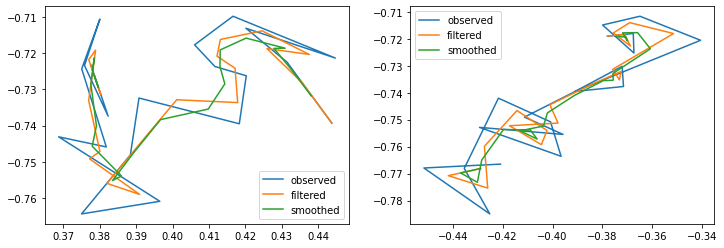

In [76]:
fig, ax = plt.subplots(1, samples, figsize=(12,4))
for i in range(samples):
    ax[i].plot(trajectories[i, :, 0], trajectories[i, :, 1], label="observed")
    ax[i].plot(filtered_means[i, :, 0], filtered_means[i, :, 1], label="filtered")
    ax[i].plot(smoothed_means[i, :, 0], smoothed_means[i, :, 1], label="smoothed")
    ax[i].legend()
    
    


## Introduction to Monte Carlo Methods

### Gibbs Sampler

### Metropolis Hastings

### Random Walk Metropolis Hastings

### Hamiltonian Monte Carlo 

### No U-Turn Sampler

### MCMC for Structural Time Series